# Use case: Using satellite observations to explain the relationship between aerosols and both near-surface and skin temperatures.  

### User Question: Is the accuracy of the AOD estimates sufficient to study the relationship between air quality and temperature in the Southeastern US?

The "satellite-aerosol-properties" catalogue provides global information on essential aerosol variables: aerosol optical depth (AOD) and fine-mode aerosol optical depth (fAOD) from 1995 to present, derived from satellite observations. The SLSTR dataset is used in the following analysis to demonstrate how this catalogue can capture the seasonal maps and monthly trends of AOD and fAOD. 

The dominant source of natural aerosols over Earth’s vast forested regions are biogenic volatile organic compounds (BVOC). Recently, studies on the emissions of BVOCs have substantially increased, as they have a significant impact on human health and climate change due to their large emissions and high reactivity. There is evidence that the temperature in the southeastern US is dependent on enhanced natural BVOC emissions on warmer days. There are several aerosol sources that could explain the temperature dependence of AOD, for example, biogenic emissions, secondary organic aerosols (SOA) formed in the aqueous phase, or biomass burning emissions. This notebook determines whether the AOD's time and spatial sampling are sufficient to support our investigation of the monthly correlation between the AOD and temperature.

### Quality assessment statement

The accuracy of the AOD from Sentinel 3 satellite is not sufficient to study the relationship between air quality and temperature in the southeastern US.

### Methodology

The analysis comprises the following steps: 

• Download AOD and fine_AOD data (AOD550 and F5_AOD500 (Aerosol properties gridded data from 1995 to present derived from satellite observations), orizontal resolution: 1° x 1°; temporal resolution: monthly);

• Compute the spatially weighted mean of AOD and fAOD; 

• Create map plots of AOD550 and fAOD550;

• Download 2 m and skin temperature data from the "ERA5-Land monthly averaged data from 1950 to present" catalog (horizontal resolution: 0.1° x 0.1°; temporal resolution: monthly);

• Plot the monthly time series of AOD550 and fine_AOD550 versus 2 m and skin temperatures.

• Plot the monthly time series of 2 m and skin temperatures.


### Analysis and Results
### Import packages

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import pandas as pd
from c3s_eqc_automatic_quality_control import diagnostics, download, plot,utils
import warnings
plt.style.use("seaborn-v0_8-notebook")
import numpy as np
from c3s_eqc_automatic_quality_control import diagnostics, download, plot,utils
warnings.filterwarnings("ignore")

### Setting up the data  request and downloading the monthly average dataset for versions v2.1 and v2.2

In [2]:
from c3s_eqc_automatic_quality_control import download

collection_id = "satellite-aerosol-properties"
request = {
    "format": "zip",
    "time_aggregation": "monthly_average",
    "variable": "aerosol_optical_depth",
    "sensor_on_satellite": "slstr_on_sentinel_3a",
    "algorithm": "ens",
}

time_dict = {
    "v2.1": {"start": "2017-07", "stop": "2020-06"},
    "v2.2": {"start": "2020-07", "stop": "2022-12"},
}

lon_slice = slice(-90, -79)
lat_slice = slice(24, 35)

ds_dict = {}
for version, kwargs in time_dict.items():
    requests = download.update_request_date(
        request | {"version": version}, **kwargs, stringify_dates=True
    )
    ds_dict[version] = download.download_and_transform(
        collection_id, requests, chunks={"year": 1, "month": 1}
    )


100%|██████████| 30/30 [00:02<00:00, 13.58it/s]


### Convert and redefine the time dimension of monthly data for the two versions 

In [3]:
ds_monthly_dict = {}
for version, ds in ds_dict.items():
    ds_monthly = ds.copy()
    ds_monthly["source"] = ds_monthly["source"].str.slice(None, 6)
    ds_monthly["source"] = pd.to_datetime(ds_monthly["source"], format="%Y%m")

    ds_monthly = ds_monthly.rename({'source': 'time'})

    ds_monthly = utils.regionalise(ds_monthly, lon_slice=lon_slice, lat_slice=lat_slice)

    ds_monthly_dict[version] = ds_monthly

for version, ds_monthly in ds_monthly_dict.items():
    print(f"Version {version}:")
    print(ds_monthly)


Version v2.1:
<xarray.Dataset> Size: 70kB
Dimensions:                      (time: 36, latitude: 11, longitude: 11)
Coordinates:
  * time                         (time) datetime64[ns] 288B 2017-07-01 ... 20...
  * latitude                     (latitude) float32 44B 24.5 25.5 ... 33.5 34.5
  * longitude                    (longitude) float32 44B -89.5 -88.5 ... -79.5
Data variables:
    AOD550                       (time, latitude, longitude) float32 17kB dask.array<chunksize=(1, 11, 11), meta=np.ndarray>
    FM_AOD550                    (time, latitude, longitude) float32 17kB dask.array<chunksize=(1, 11, 11), meta=np.ndarray>
    AOD550_UNCERTAINTY_ENSEMBLE  (time, latitude, longitude) float32 17kB dask.array<chunksize=(1, 11, 11), meta=np.ndarray>
    NMEAS                        (time, latitude, longitude) float32 17kB dask.array<chunksize=(1, 11, 11), meta=np.ndarray>
Attributes: (12/18)
    Conventions:               CF-1.6
    creator_email:             thomas.popp@dlr.de
    crea

### Combine the two monthly datasets along the version dimension.

In [4]:
ds_monthly_merged = xr.concat([ds_monthly_dict['v2.1'],ds_monthly_dict['v2.2']], dim='time')

print(ds_monthly_merged)

<xarray.Dataset> Size: 128kB
Dimensions:                      (time: 66, latitude: 11, longitude: 11)
Coordinates:
  * time                         (time) datetime64[ns] 528B 2017-07-01 ... 20...
  * latitude                     (latitude) float32 44B 24.5 25.5 ... 33.5 34.5
  * longitude                    (longitude) float32 44B -89.5 -88.5 ... -79.5
Data variables:
    AOD550                       (time, latitude, longitude) float32 32kB dask.array<chunksize=(1, 11, 11), meta=np.ndarray>
    FM_AOD550                    (time, latitude, longitude) float32 32kB dask.array<chunksize=(1, 11, 11), meta=np.ndarray>
    AOD550_UNCERTAINTY_ENSEMBLE  (time, latitude, longitude) float32 32kB dask.array<chunksize=(1, 11, 11), meta=np.ndarray>
    NMEAS                        (time, latitude, longitude) float32 32kB dask.array<chunksize=(1, 11, 11), meta=np.ndarray>
Attributes: (12/18)
    Conventions:               CF-1.6
    creator_email:             thomas.popp@dlr.de
    creator_name:    

### Visualize the results

### Calculate the seasonal mean of AOD and fAOD for the period 2017-2022.

In [5]:
ds_seas=ds_monthly_merged.groupby('time.season').mean() #seasonal mean
print(ds_seas)

<xarray.Dataset> Size: 8kB
Dimensions:                      (season: 4, latitude: 11, longitude: 11)
Coordinates:
  * latitude                     (latitude) float32 44B 24.5 25.5 ... 33.5 34.5
  * longitude                    (longitude) float32 44B -89.5 -88.5 ... -79.5
  * season                       (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    AOD550                       (season, latitude, longitude) float32 2kB dask.array<chunksize=(1, 11, 11), meta=np.ndarray>
    FM_AOD550                    (season, latitude, longitude) float32 2kB dask.array<chunksize=(1, 11, 11), meta=np.ndarray>
    AOD550_UNCERTAINTY_ENSEMBLE  (season, latitude, longitude) float32 2kB dask.array<chunksize=(1, 11, 11), meta=np.ndarray>
    NMEAS                        (season, latitude, longitude) float32 2kB dask.array<chunksize=(1, 11, 11), meta=np.ndarray>
Attributes: (12/18)
    Conventions:               CF-1.6
    creator_email:             thomas.popp@dlr.de
    creator_name:     

### Plot seasonal maps of AOD550 and fine-mode AOD550 over Southeastern US 2017-2022

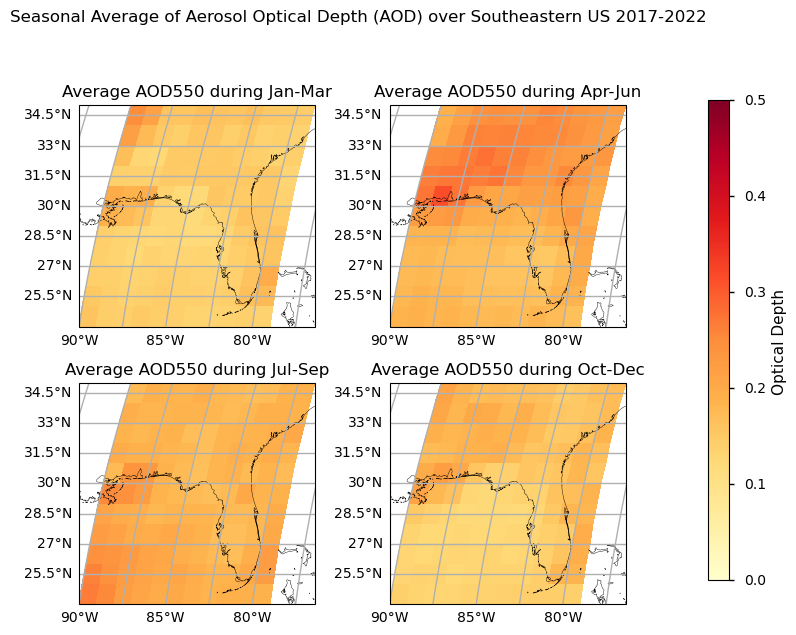

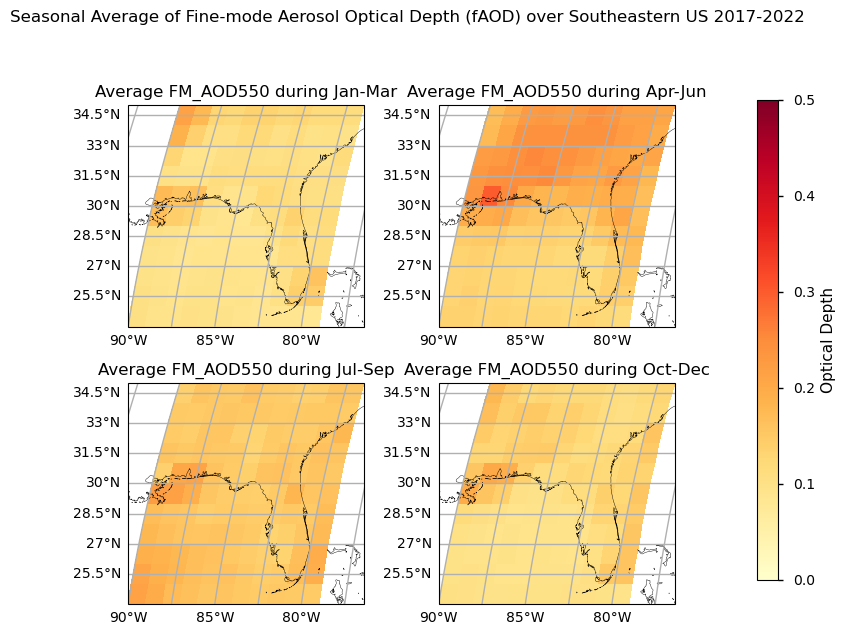

In [6]:


titles = ['Average AOD550 during Jan-Mar', 'Average AOD550 during Apr-Jun',
          'Average AOD550 during Jul-Sep', 'Average AOD550 during Oct-Dec']

map_proj = ccrs.Robinson()

p = ds_seas["AOD550"].plot.pcolormesh(cmap='YlOrRd', vmax=0.5, vmin=0, col="season", col_wrap=2,
                                      transform=ccrs.PlateCarree(),
                                      subplot_kws={"projection": map_proj},
                                      add_colorbar=False)

for ax, title in zip(p.axs.flat, titles):
    ax.coastlines()
    ax.set_title(title)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False

mappable = p.axes[0][0].collections[0]

# Create colorbar
cax = plt.axes([1, 0.1, 0.03, 0.8])
cbar = plt.colorbar(mappable, cax=cax)
cbar.set_label('Optical Depth ')

# Set the main title for the entire figure
plt.suptitle("Seasonal Average of Aerosol Optical Depth (AOD) over Southeastern US 2017-2022", y=1.05)

plt.tight_layout(rect=[0, 0, 0.95, 1])  # Adjust layout to make space for the main title
plt.show()

############
# Assuming `ds_seas` and other necessary data are already defined

titles = ['Average FM_AOD550 during Jan-Mar', 'Average FM_AOD550 during Apr-Jun',
          'Average FM_AOD550 during Jul-Sep', 'Average FM_AOD550 during Oct-Dec']

map_proj = ccrs.Robinson()

p = ds_seas["FM_AOD550"].plot.pcolormesh(cmap='YlOrRd', vmax=0.5, vmin=0, col="season", col_wrap=2,
                                         transform=ccrs.PlateCarree(),
                                         subplot_kws={"projection": map_proj},
                                         add_colorbar=False)

for ax, title in zip(p.axs.flat, titles):
    ax.coastlines()
    ax.set_title(title)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False

mappable = p.axes[0][0].collections[0]

# Create colorbar
cax = plt.axes([1, 0.1, 0.03, 0.8])
cbar = plt.colorbar(mappable, cax=cax)
cbar.set_label('Optical Depth')

# Set the main title for the entire figure
plt.suptitle("Seasonal Average of fine-mode Aerosol Optical Depth (fAOD) over Southeastern US 2017-2022", y=1.05)

plt.tight_layout(rect=[0, 0, 0.95, 1])  # Adjust layout to make space for the main title
plt.show()




### Define request for 2m_temperature (t2m)

In [7]:
collection_id_t2m = "reanalysis-era5-land-monthly-means"
request_t2m = {
    "format": "grib",
    "product_type": "monthly_averaged_reanalysis",
    "variable": "2m_temperature",
    "time": "00:00",
    "year": [ "2017","2018", "2019", "2020", "2021", "2022"],
    "month": [ "01", "02", "03", "04", "05", "06","07", "08", "09", "10", "11", "12"],
    "area": [35, -90, 24, -79],
}




### Download and transform (spatial-weighted) t2m data

In [8]:
# Download the original data
ds_t2m_original = download.download_and_transform(collection_id_t2m, request_t2m)

# Regrid the original data to match the grid of ds_monthly_merged 
import xarray as xr
ds_t2m_regrid = ds_t2m_original.interp(
    latitude=ds_monthly_merged.latitude,
    longitude=ds_monthly_merged.longitude,
    method='nearest',  # Use nearest-neighbor interpolation
)
print(ds_t2m_regrid)

# Calculate spatial weighted mean of the regridded data
da_t2m_spatial_weighted_mean = diagnostics.spatial_weighted_mean(ds_t2m_regrid)
print(da_t2m_spatial_weighted_mean) 


100%|██████████| 1/1 [00:00<00:00, 32.98it/s]


<xarray.Dataset> Size: 36kB
Dimensions:                  (forecast_reference_time: 72, latitude: 11,
                              longitude: 11)
Coordinates:
    realization              int64 8B ...
    leadtime                 timedelta64[ns] 8B ...
    surface                  float64 8B ...
    time                     (forecast_reference_time) datetime64[ns] 576B dask.array<chunksize=(72,), meta=np.ndarray>
  * forecast_reference_time  (forecast_reference_time) datetime64[ns] 576B 20...
  * latitude                 (latitude) float32 44B 24.5 25.5 26.5 ... 33.5 34.5
  * longitude                (longitude) float32 44B -89.5 -88.5 ... -80.5 -79.5
Data variables:
    t2m                      (forecast_reference_time, latitude, longitude) float32 35kB dask.array<chunksize=(72, 11, 11), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:       

### Calculate monthly mean of t2m data

In [9]:
ds_monmean_t2m = da_t2m_spatial_weighted_mean.resample(forecast_reference_time="1M").mean()
print(ds_monmean_t2m)
t2m_subset_ds = ds_monmean_t2m.sel(forecast_reference_time=slice("2017-07-01", "2022-12-31"))
print(t2m_subset_ds)

<xarray.Dataset> Size: 888B
Dimensions:                  (forecast_reference_time: 72)
Coordinates:
    realization              int64 8B 0
    leadtime                 timedelta64[ns] 8B 1 days
    surface                  float64 8B 0.0
  * forecast_reference_time  (forecast_reference_time) datetime64[ns] 576B 20...
Data variables:
    t2m                      (forecast_reference_time) float32 288B dask.array<chunksize=(72,), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-05-28T08:27 GRIB to CDM+CF via cfgrib-0.9.1...
<xarray.Dataset> Size: 816B
Dimensions:                  (forecast_reference_time: 66)
Coordinates:
    realization              int64 8B 0
    leadtime              

### Plot the monthly mean time series of AOD550 and t2m for Southeastern US during 2017-2022

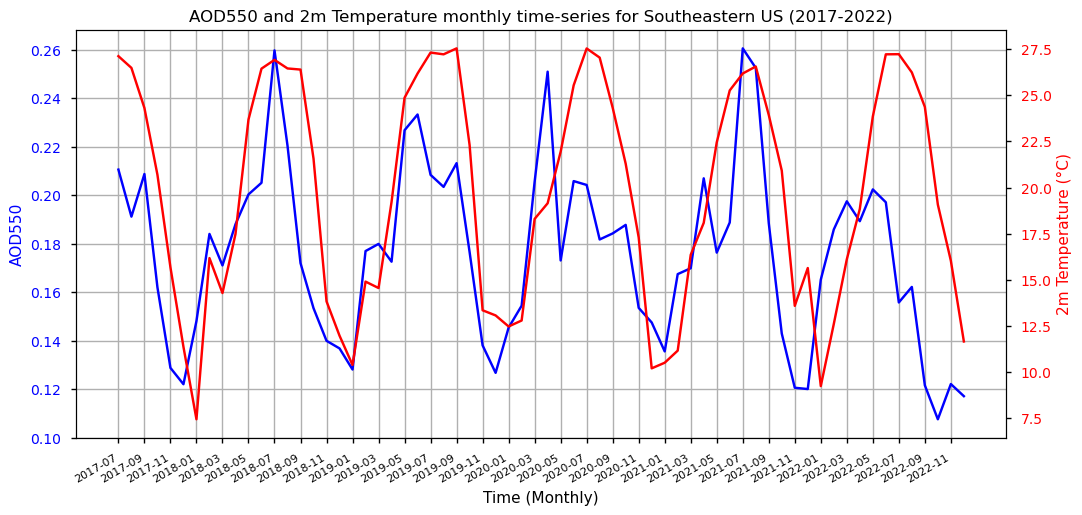

In [10]:


# Extract the Period data directly from the forecast_reference_time coordinate in ds_monmean_t2m
time_period = pd.PeriodIndex(t2m_subset_ds['forecast_reference_time'].values, freq='M')

# Define the x-axis positions and labels for quarterly intervals
positions = range(len(t2m_subset_ds['forecast_reference_time']))
monthly_labels = time_period.strftime("%Y-%m")

fig, ax1 = plt.subplots(figsize=(12, 6))
# Plot AOD550
aod_values = ds_monthly_merged["AOD550"].mean(dim=('latitude', 'longitude')).values
ax1.plot(positions, aod_values, label="AOD550", color='blue')
ax1.set_xlabel('Time (Monthly)')
ax1.set_ylabel('AOD550', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')


# Link temperature to the first axis
ax2 = ax1.twinx()
# Convert temperature to Celsius
temperature_kelvin = t2m_subset_ds["t2m"] - 273.15

# Plot temperature (t2m)
ax2.plot(positions, temperature_kelvin, label="t2m (monthly)", color='red')
ax2.set_ylabel('2m Temperature (°C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set x-axis ticks and labels for every other data point
positions = positions[::2]
monthly_labels = monthly_labels[::2]
ax1.set_xticks(positions)
ax1.set_xticklabels(monthly_labels, rotation=45, ha='right', fontsize=8)

ax1.set_title('AOD550 and 2m Temperature monthly time-series for Southeastern US (2017-2022)')
# Adding gridlines to the plot
ax1.grid(True)

# Adjust layout and display the plot
fig.autofmt_xdate()
plt.show()


### Plot the monthly mean time series of FM_AOD550 and t2m for Southeastern US during 2017-2022

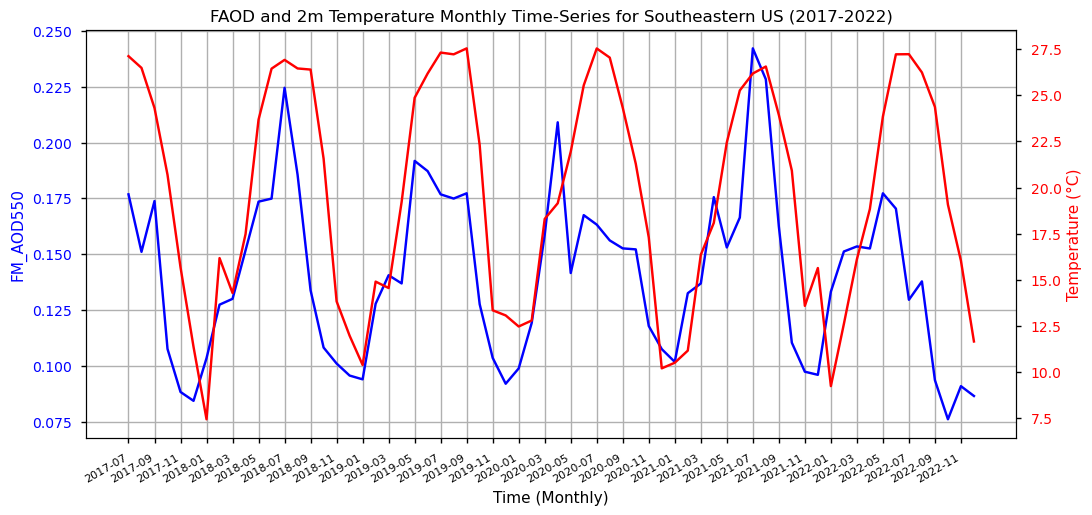

In [18]:

# Extract the Period data directly from the forecast_reference_time coordinate in ds_monmean_t2m
time_period = pd.PeriodIndex(t2m_subset_ds['forecast_reference_time'].values, freq='M')

# Define the x-axis positions and labels
positions = range(len(t2m_subset_ds['forecast_reference_time']))
monthly_labels = time_period.strftime("%Y-%m")

fig, ax1 = plt.subplots(figsize=(12, 6))
# Plot AOD550
aod_values = ds_monthly_merged["FM_AOD550"].mean(dim=('latitude', 'longitude')).values
ax1.plot(positions, aod_values, label="FM_AOD550 (Quarterly)", color='blue')
ax1.set_xlabel('Time (Monthly)')
ax1.set_ylabel('FM_AOD550', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Link temperature to the first axis
ax2 = ax1.twinx()
# Convert temperature to Celsius
temperature_kelvin = t2m_subset_ds["t2m"] - 273.15

# Plot temperature (t2m)
ax2.plot(positions, temperature_kelvin, label="t2m (Quarterly)", color='red')
ax2.set_ylabel('Temperature (°C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set x-axis ticks and labels for every other data point
positions = positions[::2]
monthly_labels = monthly_labels[::2]
ax1.set_xticks(positions)
ax1.set_xticklabels(monthly_labels, rotation=45, ha='right', fontsize=8)

ax1.set_title('FAOD and 2m Temperature Monthly Time-Series for Southeastern US (2017-2022)')
# Adding gridlines to the plot
ax1.grid(True)

# Adjust layout and display the plot
fig.autofmt_xdate()
plt.show()


### Setting up data to request for "Skin_temperature" 

In [12]:
collection_id_skin_temperature = "reanalysis-era5-land-monthly-means"
request_skin_temperature = {
    "format": "grib",
    "product_type": "monthly_averaged_reanalysis",
    "variable": "skin_temperature",
    "time": "00:00",
    "year": [ "2017","2018", "2019", "2020", "2021", "2022"],
    "month": [ "01", "02", "03", "04", "05", "06","07", "08", "09", "10", "11", "12"],
    "area": [35, -90, 24, -79],
}

### Download and transform (spatial-weighted) Skin_temperature data

In [13]:
# Download the original data
ds_skin_temperature_original = download.download_and_transform(collection_id_skin_temperature, request_skin_temperature)

# Regrid the original data to match the grid of ds_monthly_merged 
import xarray as xr
ds_skin_temperature_regrid = ds_skin_temperature_original.interp(
    latitude=ds_monthly_merged.latitude,
    longitude=ds_monthly_merged.longitude,
    method='nearest',  # Use nearest-neighbor interpolation
)
print(ds_skin_temperature_regrid)

# Calculate spatial weighted mean of the regridded data
da_skin_temperature_spatial_weighted_mean = diagnostics.spatial_weighted_mean(ds_skin_temperature_regrid)
print(da_skin_temperature_spatial_weighted_mean) 

100%|██████████| 1/1 [00:00<00:00, 33.14it/s]

<xarray.Dataset> Size: 36kB
Dimensions:                  (forecast_reference_time: 72, latitude: 11,
                              longitude: 11)
Coordinates:
    realization              int64 8B ...
    leadtime                 timedelta64[ns] 8B ...
    surface                  float64 8B ...
    time                     (forecast_reference_time) datetime64[ns] 576B dask.array<chunksize=(72,), meta=np.ndarray>
  * forecast_reference_time  (forecast_reference_time) datetime64[ns] 576B 20...
  * latitude                 (latitude) float32 44B 24.5 25.5 26.5 ... 33.5 34.5
  * longitude                (longitude) float32 44B -89.5 -88.5 ... -80.5 -79.5
Data variables:
    skt                      (forecast_reference_time, latitude, longitude) float32 35kB dask.array<chunksize=(72, 11, 11), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:       

### Calculate monthly mean of skin temperature data

In [14]:
ds_monmean_skin_temperature = da_skin_temperature_spatial_weighted_mean.resample(forecast_reference_time="1M").mean()
print(ds_monmean_skin_temperature)
skin_temperature_subset_ds = ds_monmean_skin_temperature.sel(forecast_reference_time=slice("2017-07-01", "2022-12-31"))
print(skin_temperature_subset_ds)

<xarray.Dataset> Size: 888B
Dimensions:                  (forecast_reference_time: 72)
Coordinates:
    realization              int64 8B 0
    leadtime                 timedelta64[ns] 8B 00:00:00
    surface                  float64 8B 0.0
  * forecast_reference_time  (forecast_reference_time) datetime64[ns] 576B 20...
Data variables:
    skt                      (forecast_reference_time) float32 288B dask.array<chunksize=(72,), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-05-28T08:27 GRIB to CDM+CF via cfgrib-0.9.1...
<xarray.Dataset> Size: 816B
Dimensions:                  (forecast_reference_time: 66)
Coordinates:
    realization              int64 8B 0
    leadtime            

### Plot the monthly mean time series of AOD550 and skin_temperature for Southeastern US during 2017-2022

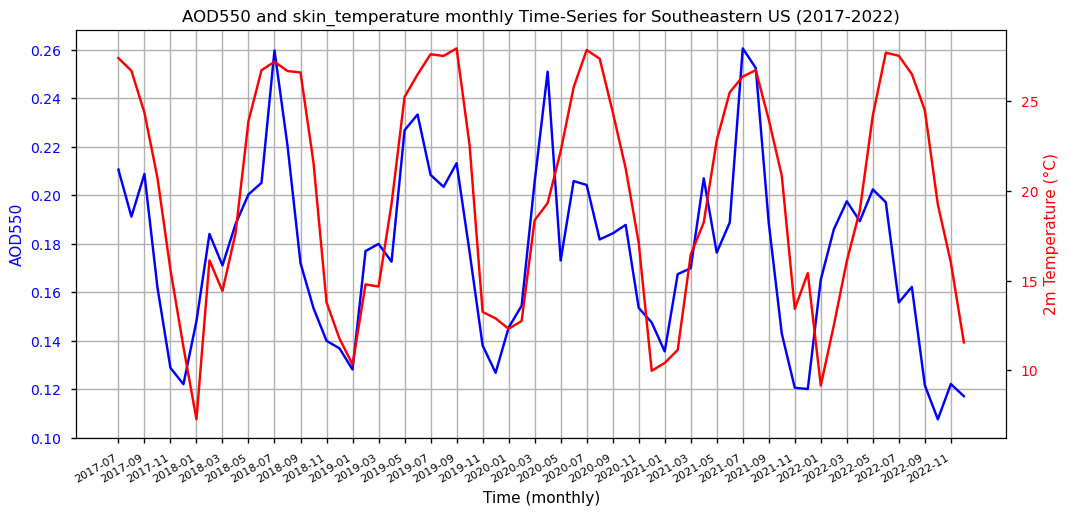

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract the Period data directly from the forecast_reference_time coordinate 
time_period = pd.PeriodIndex(skin_temperature_subset_ds['forecast_reference_time'].values, freq='M')

# Define the x-axis positions and labels
positions = range(len(skin_temperature_subset_ds['forecast_reference_time']))
monthly_labels = time_period.strftime("%Y-%m")

fig, ax1 = plt.subplots(figsize=(12, 6))
# Plot AOD550
aod_values = ds_monthly_merged["AOD550"].mean(dim=('latitude', 'longitude')).values
ax1.plot(positions, aod_values, label="AOD550", color='blue')
ax1.set_xlabel('Time (monthly)')
ax1.set_ylabel('AOD550', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')


# Link temperature to the first axis
ax2 = ax1.twinx()
# Convert temperature to Celsius
temperature_kelvin = skin_temperature_subset_ds["skt"] - 273.15

# Plot temperature (t2m)
ax2.plot(positions, temperature_kelvin, label="skt (monthly)", color='red')
ax2.set_ylabel('2m Temperature (°C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set x-axis ticks and labels for every other data point
positions = positions[::2]
monthly_labels = monthly_labels[::2]
ax1.set_xticks(positions)
ax1.set_xticklabels(monthly_labels, rotation=45, ha='right', fontsize=8)

ax1.set_title('AOD550 and skin_temperature monthly Time-Series for Southeastern US (2017-2022)')

ax1.grid(True)
fig.autofmt_xdate()
plt.show()


### Plot the monthly mean time series of FM_AOD550 and skin_temperature for Southeastern US during 2017-2022

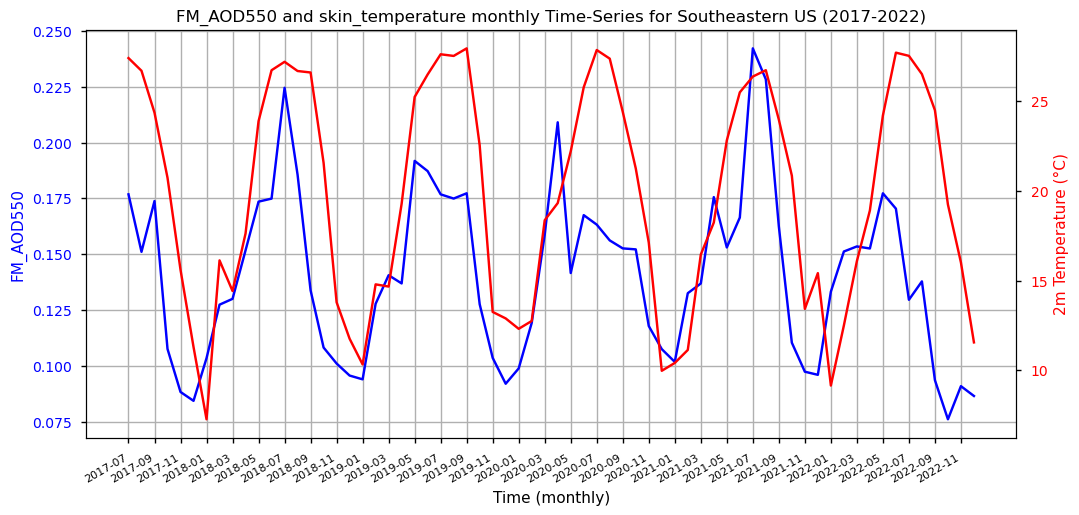

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract the Period data directly from the forecast_reference_time coordinate in ds_monmean_t2m
time_period = pd.PeriodIndex(skin_temperature_subset_ds['forecast_reference_time'].values, freq='M')

# Define the x-axis positions and labels for quarterly intervals
positions = range(len(skin_temperature_subset_ds['forecast_reference_time']))
monthly_labels = time_period.strftime("%Y-%m")

fig, ax1 = plt.subplots(figsize=(12, 6))
# Plot AOD550
aod_values = ds_monthly_merged["FM_AOD550"].mean(dim=('latitude', 'longitude')).values
ax1.plot(positions, aod_values, label="FM_AOD550 (Quarterly)", color='blue')
ax1.set_xlabel('Time (monthly)')
ax1.set_ylabel('FM_AOD550', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')


# Link temperature to the first axis
ax2 = ax1.twinx()
# Convert temperature to Celsius
temperature_kelvin = skin_temperature_subset_ds["skt"] - 273.15

# Plot temperature (t2m)
ax2.plot(positions, temperature_kelvin, label="skt (monthly)", color='red')
ax2.set_ylabel('2m Temperature (°C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set x-axis ticks and labels for every other data point
positions = positions[::2]
monthly_labels = monthly_labels[::2]
ax1.set_xticks(positions)
ax1.set_xticklabels(monthly_labels, rotation=45, ha='right', fontsize=8)

ax1.set_title('FM_AOD550 and skin_temperature monthly Time-Series for Southeastern US (2017-2022)')
# Adding gridlines to the plot
ax1.grid(True)

# Adjust layout and display the plot
fig.autofmt_xdate()
plt.show()


### Plot the monthly mean time series of 2m_temperature and skin_temperature for Southeastern US during 2017-2022

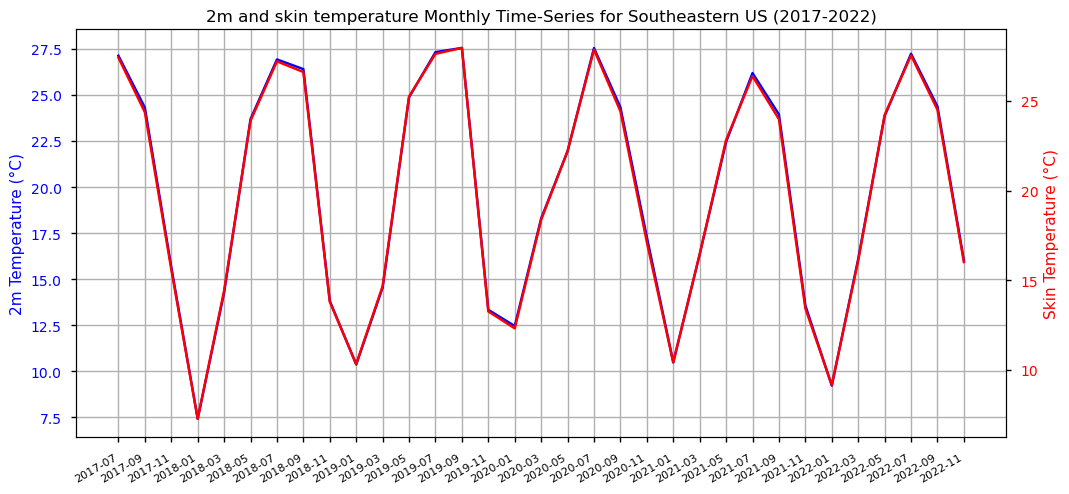

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract the Period data directly from the forecast_reference_time coordinate in t2m_subset_ds
time_period = pd.PeriodIndex(skin_temperature_subset_ds['forecast_reference_time'].values, freq='M')

# Define the x-axis positions and labels for every other month
positions = range(0, len(skin_temperature_subset_ds['forecast_reference_time']), 2)
monthly_labels = time_period[::2].strftime("%Y-%m")

fig, ax1 = plt.subplots(figsize=(12, 6))
# Link temperature to the first axis
ax2 = ax1.twinx()
# Convert temperature to Celsius
temperature_skin_kelvin = skin_temperature_subset_ds["skt"] - 273.15
temperature_t2m_kelvin = t2m_subset_ds["t2m"] - 273.15

# Plot temperature (t2m)
ax1.plot(positions, temperature_t2m_kelvin[::2], label="temperature_2m (Monthly)", color='blue')
ax1.set_ylabel('2m Temperature (°C)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax1.set_xticks(positions)
ax1.set_xticklabels(monthly_labels, rotation=45, ha='right', fontsize=8)
ax1.set_title('2m and skin temperature Monthly Time-Series for Southeastern US (2017-2022)')
# Adding gridlines to the plot
ax1.grid(True)
# Plot temperature (skin_temperature)
ax2.plot(positions, temperature_skin_kelvin[::2], label="skin_temperature (Monthly)", color='red')
ax2.set_ylabel('Skin Temperature (°C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Adjust layout and display the plot
fig.autofmt_xdate()
plt.show()


### Main outcomes
1. Considering the spatial maps of AOD and fAOD for the period 2017–2022 in the southeastern US, the highest values of AOD and fAOD were observed during the summer.
2. In the literature, the near-surface temperature in the southeastern US was demonstrated to depend on enhanced natural BVOC emissions on warmer days (Liu, W., 2005; Xu, L., 2015). The impact of fAOD and total AOD on temperature over the southeastern US shows that there is not a straightforward correlation between temperature and AOD (total and fine mode), allowing us to support the thesis of a strong correlation between aerosols due to anthropogenic emissions and near-surface temperature. Also, the time and spatial sampling of the AOD estimates are not sufficient to study the relationship between air quality and temperature in the southeastern US.
3. The monthly time series mapping of 2 m temperature and skin temperature indicates a notable positive correlation between these variables, demonstrating consistency between the two products.


#References
1- Liu, W., Wang, Y., Russell, A. and Edgerton, E.S., 2005. Atmospheric aerosol over two urban–rural pairs in the southeastern United States: Chemical composition and possible sources. Atmospheric Environment, 39(25), pp.4453-4470.
2- Xu, L., Suresh, S., Guo, H., Weber, R.J. and Ng, N.L., 2015. Aerosol characterization over the southeastern United States using high-resolution aerosol mass spectrometry: spatial and seasonal variation of aerosol composition and sources with a focus on organic nitrates. Atmospheric Chemistry and Physics, 15(13), pp.7307-7336.